# Active-learning example with MNIST data for digit recognition

The goal of this notebook is to show how a simple active-learning campaign can be designed for digit recognition using CAMD.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.datasets import fetch_openml
from camd.agent.base import RandomAgent, HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.experiment.base import ATFSampler
from camd.campaigns.base import Campaign
from scipy.stats import entropy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.exceptions import NotFittedError
path = os.getcwd()

Let's fetch the MNIST dataset by LeCun et al. from OpenML

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
df = pd.DataFrame(X)
df['target'] = y.values
df = df.astype(int)
df.index = df.index.map(str)

Dataset has 70,000 labeled instances of hand written digits in 28x28 resolution. We'll use 10,000 for testing our active-learning model. Use 60000 for active-learning itself.

In [4]:
print(df.shape)

(70000, 785)


This is what a typical example looks like:

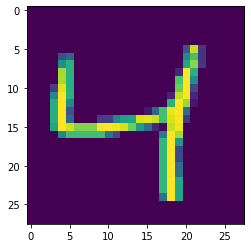

In [5]:
plt.imshow(X.values[2, :-1].astype(int).reshape(28,28))

Let's prepare our data for camd.Campaign

In [6]:
test_df = df.sample(10000, random_state=42) # setting aside 10,000 examples for testing
learn_df = df.drop(test_df.index, axis=0)
print(learn_df.shape)

(60000, 785)


Now let's construct an Agent that tries to choose the next set of examples to be labeled by a human oracle (which corresponds to the Experiment class in camd). Note we have 10 digits (hence classes), this for each example we get 10 probability estimations for belonging to digit classes

Our Agents strategy is to pick the examples where the class assignments are the most undecided, which we quantify by calculating the entropy of the predicted probabilities from 0 to 9. The larger the entropy, the closer the point is to the ``decision boundaries`` of the classifier.

Given the seed data and candidate data, our Agent will simply return a list of N_query number of examples to send for labeling.

In [7]:
class DecisionBoundary(HypothesisAgent):
    def __init__(self, candidate_data=None, seed_data=None, 
                 N_query=None, classifier=None):
        self.candidate_data = candidate_data
        self.seed_data = seed_data
        self.N_query = N_query if N_query else 1
        self.cv_score = np.nan
        self.classifier = classifier
        super(DecisionBoundary).__init__()
        
    def get_hypotheses(self, candidate_data, seed_data=None):
        self.candidate_data = candidate_data.drop(columns=['target'], axis=1)
        self.seed_data = seed_data
        X_train = seed_data.drop(columns=['target'], axis=1)
        y_train = seed_data['target']
        
        # CV score from acquired data
        # cv_score = cross_val_score(self.classifier, X_train, y_train,
        #                            cv=KFold(3, shuffle=True))
        # self.cv_score = np.mean(cv_score)
        
        # Fit the main model, make predictions and request new experiments based on entropy
        self.classifier.fit(X_train, y_train)
        probabs = self.classifier.predict_proba(self.candidate_data)
        self.probabs = probabs
        neg_entropies = [-1*entropy(probabs[i]) for i in range(len(probabs))]
        selected = np.argsort(neg_entropies)[:self.N_query]
        selected = candidate_data.iloc[selected]
        return selected

We design an `Analyzer` to test the active-learning model against the independent test set and stores the scores. It evaluates the performance of the latest fit classifier on the test data. Note that the analyzer acts on the `Campaign` object, which has both an experiment and agent to conduct iteration and campaign-wide retrospectives.

In [8]:
class MnistAnalyze(AnalyzerBase):
    def __init__(self, test_df):
        self.score = []
        self.test_df = test_df
        
    def analyze(self, campaign, finalize=False):
        new_results = campaign.experiment.get_results()
        X = new_results.drop(columns=['target'], axis=1)
        y = new_results['target']
        try:
            iteration_score = campaign.agent.classifier.score(X, y)
            overall_score = campaign.agent.classifier.score(
                test_df.drop('target', axis=1), test_df['target']
            )
        except NotFittedError as e:
            iteration_score = None
            overall_score = None
        summary = pd.DataFrame(
            {"iteration_score": [iteration_score],
             "overall_score": [overall_score]
            }
        )
        return summary

We will now setup our active learning campaign simulation by specifying the hyperparameters of the loop, such as the maximum number of queries allowed in each iteration, number of examples to pick as the seed, `Agent`, `Analyzer` and `Experiment` classes (and their parameters) to be used. Here we are using the `ATFSampler` class as the experiment, which helps perform an after-the-fact simulation by simply looking up the results from the provided dataframe. 

In [9]:
N_query = 500  # This many new examples are asked to oracle in each iteration (labeled by humans in reality)
N_seed = 2000  # This many samples are randomly acquired in the beginning to form a seed.
N_iter = 10
candidate_data = learn_df
classifier = LogisticRegression(
    C=50./X.shape[1],
    multi_class='multinomial',
    penalty='l1',
    solver='saga',
    tol=0.1
)

agent = DecisionBoundary(
    N_query=N_query,
    classifier=classifier
)
analyzer = MnistAnalyze(
    test_df=test_df
)
experiment = ATFSampler(dataframe=df)

Let's construct a `Campaign`, which will execute the entire campaign.

In [10]:
campaign_path = os.path.join(path, 'mnist-entropy')
shutil.rmtree(campaign_path, ignore_errors=True)
os.makedirs(campaign_path)
campaign = Campaign(
    candidate_data, agent, experiment, analyzer,
    path=campaign_path,
    create_seed=N_seed
)

In [11]:
campaign.auto_loop(n_iterations=N_iter, initialize=True)

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent DecisionBoundary hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent DecisionBoundary hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent DecisionBoundary hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent DecisionBoundary hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 s

In [12]:
campaign.history

,iteration_score,overall_score
0,NaN,NaN
1,0.334,0.8861
2,0.356,0.8863
3,0.440,0.8884
4,0.440,0.8903
5,0.448,0.8942
6,0.532,0.8956
7,0.566,0.8948
8,0.570,0.8945
9,0.586,0.8967


### Next: Simulations, confidence intervals and baselines

How confident are we with this simulation? In the next step, we will run multiple versions of this simulation with different seeds to build a confidence bound around our learning curve. In addition, we will simulate a strong baseline to compare: i.e. random acquisition. Random acquisition is not easy when the goal is to improve prediction accuracy at minimal acquisition cost. 

We parallelize this a little bit.

In [13]:
from multiprocessing import Pool

In [14]:
np.random.randint(1, 100000)

61814

In [15]:
def entropy_campaign(i):
    loop_dir = os.path.join(path,'mnist-entropy-{}'.format(i))
    shutil.rmtree(loop_dir, ignore_errors=True)
    os.mkdir(loop_dir)
    classifier = LogisticRegression(
        C=50./X.shape[1],
        multi_class='multinomial',
        penalty='l1',
        solver='saga',
        tol=0.1
    )
    agent = DecisionBoundary(
        N_query=N_query,
        classifier=classifier
    )
    loop = Campaign(
        candidate_data, agent, experiment, analyzer,
        path=loop_dir, create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=N_iter, initialize=False)
    return loop.history

In [16]:
with Pool() as pool:
    entropy_results = pool.map(entropy_campaign, range(8))

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Iteration: 0
Campaign 0 state: Getting new results
Iteration: 0
Campaign 0 state: Getting new results
Ite

Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing results
Campaign 4 state: Agent DecisionBoundary hypothesizing
Campaign 4 state: Agent DecisionBoundary hypothesizing
Campaign 4 state: Agent DecisionBoundary hypothesizing
Campaign 4 state: Agent DecisionBoundary hypothesizing
Campaign 4 state: Agent DecisionBoundary hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results
Campaign 5 state: Agent DecisionBoundary hypothesizing
Campaign 5 state: Agent DecisionBoundary hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results

  Waiting for next round ...
Iteration: 9
Campaign 9 state: Getting new results
Campaign 9 state: Analyzing results
Campaign 8 state: Running experiments
  Waiting for next round ...
Iteration: 9
Campaign 9 state: Getting new results
Campaign 9 state: Analyzing results
Campaign 9 state: Agent DecisionBoundary hypothesizing
Campaign 8 state: Running experiments
  Waiting for next round ...
Iteration: 9
Campaign 9 state: Getting new results
Campaign 9 state: Analyzing results
Campaign 9 state: Agent DecisionBoundary hypothesizing
Campaign 9 state: Agent DecisionBoundary hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing results
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing results
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 stat

Let's also run similar simulations with a randomly aquiring agent: `RandomAgent`

In [17]:
agent_random = RandomAgent(n_query=N_query)

In [18]:
class MnistAnalyzeRandom(AnalyzerBase):
    def __init__(self, test_df):
        self.score = []
        self.test_df = test_df
        
    def analyze(self, campaign, finalize=False):
        new_results = campaign.experiment.get_results()
        seed_data = campaign.seed_data
        if len(seed_data) > 0:
            X = new_results.drop(columns=['target'], axis=1)
            y = new_results['target']
            classifier = LogisticRegression(
                C=50./70000,
                multi_class='multinomial',
                penalty='l1',
                solver='saga',
                tol=0.1
            )
            classifier.fit(seed_data.drop(columns=['target'], axis=1),
                           seed_data['target']
                          )
            iteration_score = classifier.score(X, y)
            overall_score = classifier.score(
                test_df.drop('target', axis=1), test_df['target']
            ) 
        else:
            iteration_score = None
            overall_score = None
        summary = pd.DataFrame(
            {"iteration_score": [iteration_score],
             "overall_score": [overall_score]
            }
        )
        return summary

In [19]:
def random_campaign(i):
    loop_dir = os.path.join(path,'mnist-random-{}'.format(i))
    shutil.rmtree(loop_dir, ignore_errors=True)
    os.mkdir(loop_dir)
    analyzer_random = MnistAnalyzeRandom(test_df=test_df)
    loop = Campaign(candidate_data, agent_random, experiment, analyzer_random,
                    create_seed=N_seed, path=loop_dir)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=N_iter)
    return loop.history

In [20]:
with Pool() as pool:
    random_results = pool.map(random_campaign, range(8))

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Iteration: 0
Campa

Campaign 5 state: Analyzing results
Campaign 4 state: Agent RandomAgent hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Campaign 4 state: Agent RandomAgent hypothesizing
Iteration: 5
Campaign 5 state: Getting new results
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results
Campaign 5 state: Analyzing results
Campaign 4 state: Agent RandomAgent hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results
Campaign 4 state: Agent RandomAgent hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 4 state: Agent RandomAgent hypothesizing
Campaign 4 state: Running experiments
Campaign 5 state: Analyzing results
  Waiting for next round ...
Iteration: 5
Campaign 5 state: 

Campaign 9 state: Agent RandomAgent hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing results
Campaign 9 state: Agent RandomAgent hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 9 state: Agent RandomAgent hypothesizing
Campaign 9 state: Running experiments
Campaign 10 state: Analyzing results
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing results
Campaign 9 state: Agent RandomAgent hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing results
Campaign 9 state: Agent RandomAgent hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Ca

Putting our results together.

In [21]:
from matplotlib import pyplot as plt

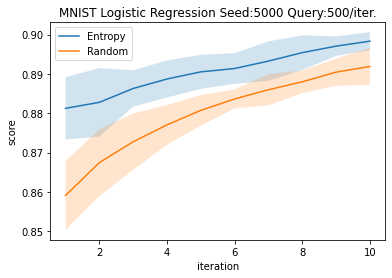

In [22]:
merged1 = np.array([history.overall_score for history in entropy_results])
merged2 = np.array([history.overall_score for history in random_results])
mu1 = np.mean(merged1, axis=0)
mu2 = np.mean(merged2, axis=0)
std1 = np.std(merged1, axis=0)
std2 = np.std(merged2, axis=0)

plt.fill_between(range(len(mu1)), mu1+2*std1, mu1-2*std1, alpha=0.2)
plt.plot(mu1, label='Entropy')
plt.fill_between(range(len(mu2)), mu2+2*std2, mu2-2*std2, alpha=0.2)
plt.plot(mu2, label='Random')
plt.title('MNIST Logistic Regression Seed:5000 Query:500/iter.')
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()

We find that the accuracy of a Logistic Regression classifier for MNIST data can be improved more quickly with active-learning via entropy-based acquisition, compared to random acquisition of new labels.